In [1]:
from utils import *

In [2]:
def parse_timestamps(df):
    '''
    It looks like the visit_timestamp is a duplicate of the visit_date, so we'll
    drop it and parse visit_date instead. Same deal for the event_time and
    event_timestamp columns.
    '''
    return df.assign(
        visit_date=pd.to_datetime(df['visit_date'], format='%Y-%m-%dT%H:%M:%S'),
        event_time=pd.to_datetime(df['event_time'], format='mixed'),
    ).drop(columns=['visit_timestamp', 'event_timestamp'])

In [3]:
def split_coordinates(df):
    """
    Split the coordinates column into separate latitude and longitude columns.
    """
    df = df.copy()
    df[['longitude', 'latitude']] = df['coordinates'].str.split(',', expand=True)
    df['longitude'] = df['longitude'].astype(np.float32)
    df['latitude'] = df['latitude'].astype(np.float32)
    return df

In [4]:
new_names = {
    'Vehicle#': 'vehicle_id',
    'District': 'district',
    'Column1.visit_date': 'visit_date',
    'Column1.visit_date.date.time': 'visit_timestamp',
    'Column1.control_group_data': 'control_group',
    'Column1.workzone_id': 'workzone_id',
    'Column1.cause': 'cause',
    'Column1.message': 'message',
    'Column1.points.features.geometry.coordinates': 'coordinates',
    'Column1.points.features.properties.speed': 'speed',
    'Column1.points.features.properties.bearing': 'bearing',
    'Column1.points.features.properties.timestamp': 'event_time',
    'Column1.points.features.properties.timestamp.date.time': 'event_timestamp',
    'Column1.points.features.properties.accel': 'acceleration',
    'Column1.points.features.properties.brake_avg': 'brake_average',
    'Column1.points.features.properties.brake_max': 'brake_maximum',
    'Column1.points.features.properties.brake_start': 'brake_start',
    'Column1.points.features.properties.brake_stop': 'brake_stop'
}
column_names = list(new_names.values())

In [5]:
# Specifying these dtypes takes memory usage down from 3GB to 700MB!
dtype_spec = {
    'vehicle_id': pd.UInt32Dtype(),
    'district': pd.UInt8Dtype(), 
    'control_group': bool,
    'speed': np.float32,
    'bearing': np.float32,
    'acceleration': np.float32,
    'brake_average': np.float32,
    'brake_maximum': np.float32,
    'brake_start': np.float32,
    'brake_stop': np.float32
}

In [6]:
df = (
    pd.read_csv('data.csv', names=column_names, skiprows=1,
                dtype=dtype_spec)
    .pipe(parse_timestamps)
    .pipe(split_coordinates)
)
df

,vehicle_id,district,visit_date,control_group,...,brake_start,brake_stop,longitude,latitude
0,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.05,32.67
1,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
2,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
...,...,...,...,...,...,...,...,...,...
9665540,251592,11,2024-12-23 23:59:45,False,...,NaN,NaN,-117.35,33.18
9665541,251592,11,2024-12-23 23:59:45,False,...,NaN,NaN,-117.35,33.18
9665542,251592,11,2024-12-23 23:59:45,False,...,NaN,NaN,-117.35,33.18


In [7]:
display_df(df.iloc[0].to_frame(), rows=18)

,0
vehicle_id,210821
district,11
visit_date,2024-11-23 00:00:33
control_group,False
workzone_id,8-7483
cause,Miscellaneous Work
message,Slow down.
coordinates,"-117.0457137,32.669405"
speed,59.4
bearing,237.0


In [8]:
df['vehicle_id'].nunique()

33594

In [9]:
df['district'].value_counts()

district
11    6301007
2     3364536
Name: count, dtype: Int64

In [10]:
df['visit_date'].describe()

count                          9665543
mean     2024-12-09 07:51:28.343904512
min                2024-11-23 00:00:33
25%                2024-12-04 12:40:18
50%                2024-12-09 20:45:14
75%                2024-12-16 19:15:06
max                2024-12-23 23:59:45
Name: visit_date, dtype: object

In [11]:
df['control_group'].value_counts()

control_group
False    7885283
True     1780260
Name: count, dtype: int64

In [12]:
df['message'].value_counts()

message
Slow down.           4043241
Right Lane Closed    2422055
Left Lane Closed     1410213
Name: count, dtype: int64

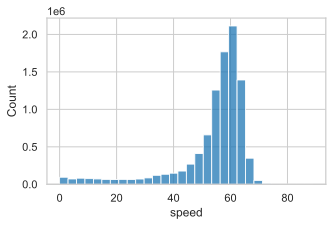

In [19]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df, x='speed', bins=30);

## Plotting individual vehicle data

In [24]:
vehicle = 210821
v1 = df.query('vehicle_id == @vehicle')
v1

,vehicle_id,district,visit_date,control_group,...,brake_start,brake_stop,longitude,latitude
0,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.05,32.67
1,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
2,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
...,...,...,...,...,...,...,...,...,...
282,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
283,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
284,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66


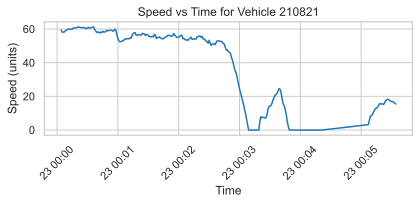

In [30]:
# Create the plot
plt.figure(figsize=(6, 3))
sns.lineplot(data=v1, x='event_time', y='speed')

# Customize the plot
plt.title(f'Speed vs Time for Vehicle {vehicle}')
plt.xlabel('Time')
plt.ylabel('Speed (units)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

Dropdown(description='Vehicle ID:', options=(np.uint32(210821), np.uint32(211092), np.uint32(211093), np.uint3…

<Figure size 1000x500 with 0 Axes>

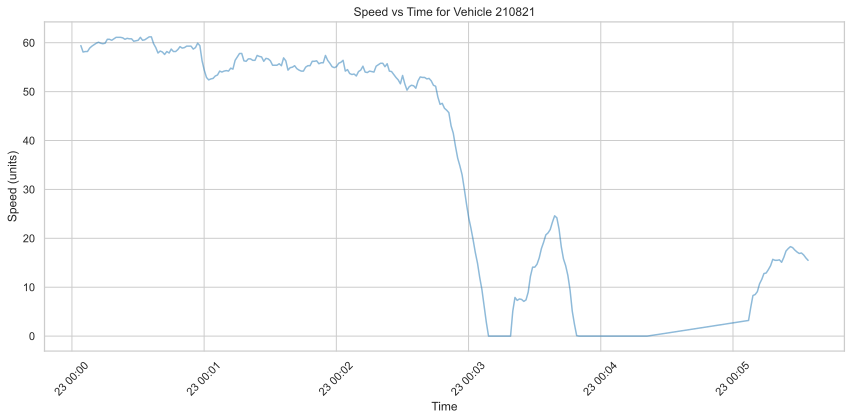

In [34]:
import ipywidgets as widgets
# Get unique vehicle IDs for the dropdown
vehicle_ids = sorted(df['vehicle_id'].unique())

# Create dropdown widget
vehicle_selector = widgets.Dropdown(
    options=vehicle_ids,
    value=vehicle_ids[0],  # Set first vehicle as default
    description='Vehicle ID:',
    style={'description_width': 'initial'}
)

# Create plot function
def plot_vehicle_speed(vehicle_id):
    # Clear previous plot
    plt.clf()
    
    # Filter data for selected vehicle
    v1 = df.query('vehicle_id == @vehicle_id')
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create both line and scatter plots
    sns.lineplot(data=v1, x='event_time', y='speed', alpha=0.5)
    # sns.scatterplot(data=v1, x='event_time', y='speed', alpha=0.7)
    
    # Customize the plot
    plt.title(f'Speed vs Time for Vehicle {vehicle_id}')
    plt.xlabel('Time')
    plt.ylabel('Speed (units)')
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Create interactive widget
def on_vehicle_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_vehicle_speed(change['new'])

# Connect the widget to the callback function
vehicle_selector.observe(on_vehicle_change, names='value')

# Display the widget and initial plot
display(vehicle_selector)
plot_vehicle_speed(vehicle_ids[0])